### Pytorch 做標準全連結 II

現在我們有點熟悉 Pytorch 的運作方式, 不過不知大家有沒有發現其實我們並沒有做 minibatch 的訓練! 這次我們想辦法來改善一下...

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
import torch.nn as nn
from torch.optim import SGD

In [9]:
from torch.utils.data import DataLoader

### 1. 讀入 MNSIT 數據集

In [3]:
from torchvision import datasets

In [4]:
mnist_train = datasets.MNIST('./data', train=True,  
                             download=True)

測試資料讀入應該就沒有問題了。

In [5]:
mnist_test = datasets.MNIST('./data', train=False,  
                             download=True)

#### 你也可以讀入 Fasion 版的 MNIST

In [5]:
# 

### 2. st

原本 $28 \times 28$ 的矩陣, 我們改為 784 維的向量, 並且都除以 255。要注意在 `pytorch` 的 tensor 運算中, 255 要很明確的告訴 `pytorch` 是浮點數

In [18]:
no_train = len(mnist_train)
no_test = len(mnist_test)

In [19]:
x_train = mnist_train.data.reshape(no_train, 784) / 255.
x_test = mnist_test.data.reshape(no_test, 784) / 255.

再來是訓練和測試資料的輸出 (正確答案)。這裡有個 `pytroch` 小技巧, 就是等等我們用 Cross Entropy 當 loss function 的時候, `pytorch` 不需要把我們這些輸出改為 one-hot encoding, 計算時自動會依 one-hot encoding 去計算。

In [20]:
y_train = mnist_train.targets
y_test = mnist_test.targets

### 2. step 1: 打造神經網路

打造神經網路和 `tf.Keras` 風非常像! 如果要做兩層隱藏層, 各 100 個神經元是這樣做的。

In [6]:
model = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10))

再次注意輸出層沒有用 `Softmax`, 這是 (再一次) `pytorch` 的 Cross Entropy 就內建了。

### 定義 (選擇) 我們的 loss function 和優化方式

In [7]:
loss_fcn = nn.CrossEntropyLoss()

In [8]:
optimizer = SGD(model.parameters(), lr=0.087)

### 3. step 2: 訓練

現在我們要用 `DataLoader` 把我們的數據依要求的 batch size 分小群再做訓練!

In [12]:
bs = 32
epochs = 10

In [27]:
for i in range(epochs):
    # 分 minibatch, num_workers=2 是一個技術型的設定
    loader = DataLoader(mnist_train, batch_size=bs,
                        shuffle=True, num_workers=2)
    for data in loader:
        x, y = data
        x = x.reshape(bs, 784)/255.
        predict = model(x)
        loss = loss_fn(predict, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    _, predict_class = torch.max(model(x_train), 1)
    acc = (predict_class == y_train).sum() / float(no_train)*100
    print(f"【第 {i+1} 回】正確率為 {acc:.2f}%")
        
    

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/yenlung/anaconda3/envs/torch-py37/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/yenlung/anaconda3/envs/torch-py37/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/yenlung/anaconda3/envs/torch-py37/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/yenlung/anaconda3/envs/torch-py37/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/yenlung/anaconda3/envs/torch-py37/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 86, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


In [52]:
trainloader = DataLoader(mnist_train, batch_size=bs,
                    shuffle=True, num_workers=0)

In [53]:
trainloader

In [54]:
for data in trainloader:
    pass

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

也可欣賞一下 loss 大小。

In [32]:
loss

tensor(2.2964, grad_fn=<NllLossBackward>)

這時我們可以對 loss 做 gradient descent, 不過因為每次要調的大小預設是累進的, 所以我們要做個 gradient 歸零的動作。

In [33]:
optimizer.zero_grad()

接著對 loss 做 backpropagation。

In [34]:
loss.backward()

再把參數更新!

In [35]:
optimizer.step()

計算一下正確率...

In [36]:
predict = model(x_train)

In [43]:
_, predict_class = torch.max(predict, 1)

In [50]:
acc = (predict_class == y_train).sum() / float(no_train)*100

In [52]:
print(f"目前正確率 {acc:.2f}%")

目前正確率 16.82%


現在合起來做!

In [86]:
predict = model(x_train)

for i in range(10):
    loss = loss_fn(predict, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    predict = model(x_train)
    _, predict_class = torch.max(predict, 1)
    acc = (predict_class == y_train).sum() / float(no_train)*100
    print(f"目前正確率 {acc:.2f}%")

目前正確率 90.00%
目前正確率 90.01%
目前正確率 90.01%
目前正確率 90.03%
目前正確率 90.04%
目前正確率 90.05%
目前正確率 90.06%
目前正確率 90.06%
目前正確率 90.05%
目前正確率 90.06%


### 6. step 3: 預測 (testing)

In [87]:
predict = model(x_test)
_, predict_class = torch.max(predict, 1)

In [88]:
acc = (predict_class == y_test).sum() / float(no_test)*100
print(f"測試資料正確率為 {acc:.2f}%")

測試資料正確率為 90.38%


神經網路預測是: tensor(2)


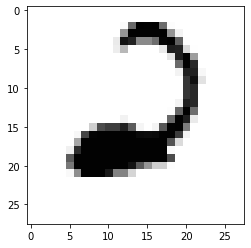

In [90]:
n = 9487

print('神經網路預測是:', predict_class[n])
plt.imshow(x_test[n].reshape(28,28), cmap='Greys');